In [1]:
# Code from Ali

import numpy as np
from squirrel.iterstream import IterableSource


def distance(l):
    """
    Measures the distance between items in the list wrt their ind position, in the range of [0, 1].
    It is assumes that the original list is list(range(N)), so if `l` is 
    identical to this, the distance would be 0, and if `l` is l[::-1], it's 1.
    """
    ll = np.array(l)
    idxs = np.array(range(len(l)))
    diff = np.abs(idxs - ll)
    dis = np.sum(diff) / len(diff)
    dis = dis / len(diff) * 2

    return dis

N = 1_000_000
distances = []
for init in [100, 1000, 10_000]:
    for size in [1000, 10_000, 50_000, 100_000]:
        if size <= init:
            continue
        shuffled = IterableSource(range(N)).shuffle(initial=init, size=size).collect()
        distances.append((init, size, distance(shuffled)))

for i in distances:
    print(i)

(100, 1000, 0.0014701656399999999)
(100, 10000, 0.014573546612)
(100, 50000, 0.069736815368)
(100, 100000, 0.13166431224)
(1000, 10000, 0.014573918412000002)
(1000, 50000, 0.069832683964)
(1000, 100000, 0.131927334132)
(10000, 50000, 0.07046382730400001)
(10000, 100000, 0.13326664843199998)


# Quantify Randomness of squirrel shuffle
Shuffle gives us a distribution over trajectories when it's run multiple times. What we want is that those trajectories (the order in which the training examples are sampled) is truly random - meaning we have a uniform distribution over all trajectories. We can use an entropy of the observed distribution of trajectories to measure the effectiveness of shuffle with different parameters.

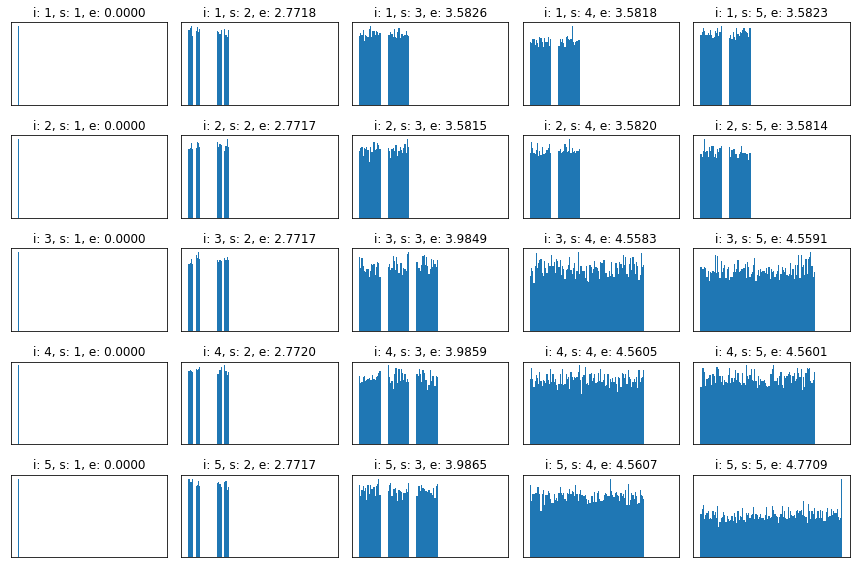

In [57]:
from itertools import permutations
from squirrel.iterstream import IterableSource
import matplotlib.pyplot as plt 
from scipy.stats import entropy
import numpy as np

N = 5
runs = 10_000

all_keys = list(permutations(range(N)))
f, ax = plt.subplots(5, 5, figsize=(12, 8))

for init in range(5):
    for size in range(5):
        sampled = []
        shuffled = IterableSource(range(N)).shuffle(initial=init+1, size=size+1)

        for i in range(runs):
            result = shuffled.collect()
            sampled.append(all_keys.index(tuple(result)))

        ax[init][size].axes.get_xaxis().set_visible(False)
        ax[init][size].axes.get_yaxis().set_visible(False)

        hist, _ = np.histogram(sampled, bins=range(len(all_keys)))
        ax[init][size].set_title(f"i: {init+1}, s: {size+1}, e: {entropy(hist):.4f}")
        ax[init][size].hist(sampled, bins=range(len(all_keys)))

plt.tight_layout()
plt.show()

In [2]:
from squirrel.driver import MapDriver
import numpy as np

class MyShardedDriver(MapDriver):

    name = "my_sharded_driver"

    def __init__(self, num_shard: int, shard_size: int):
        self.shard_size = shard_size
        self.key_it = range(num_shard)
        self.data = np.arange(num_shard * shard_size)

    def get(self, key: str):
        return self.data[int(key) * self.shard_size: (int(key)+1) * self.shard_size]

    def keys(self):
        yield from map(str, self.key_it)

    def get_iter(self, flatten: bool = True, **kwargs):
        return super().get_iter(flatten=flatten, **kwargs)

We can do the same very simple experiment for sharded datasets and investigate the shuffle buffers for keys and items. Interestingly the distribution for maximum size of key and item buffer is not uniform.

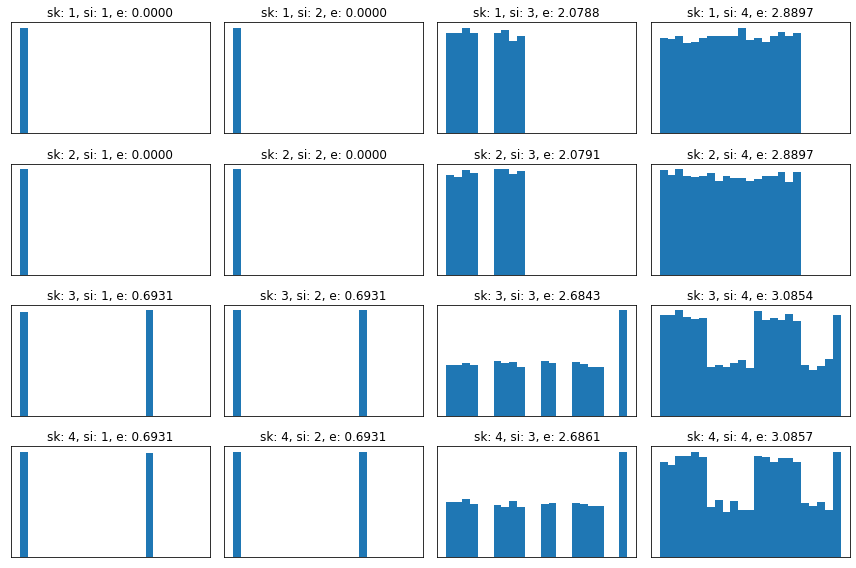

In [8]:
from itertools import permutations
from squirrel.iterstream import IterableSource
import matplotlib.pyplot as plt 
from scipy.stats import entropy
import numpy as np

N = 4
num_shard = 2
shard_size = N // num_shard
driver = MyShardedDriver(num_shard, shard_size)
runs = 10_000

all_keys = list(permutations(range(N)))
f, ax = plt.subplots(N, N, figsize=(12, 8))

# shuffle key buffer should be less or equal to number of shards
# shuffle item buffer should be at least 2
# try to fix those two numbers to something reasonable
# shuffle key buffer should always be high (max number)
for shuffle_key_buffer in range(N):
    for shuffle_item_buffer in range(N):
        sampled = []

        for i in range(runs):
            iter = driver.get_iter(shuffle_key_buffer=shuffle_key_buffer, shuffle_item_buffer=shuffle_item_buffer)
            result = iter.collect()
            sampled.append(all_keys.index(tuple(result)))

        ax[shuffle_key_buffer][shuffle_item_buffer].axes.get_xaxis().set_visible(False)
        ax[shuffle_key_buffer][shuffle_item_buffer].axes.get_yaxis().set_visible(False)

        hist, _ = np.histogram(sampled, bins=range(len(all_keys)))
        ax[shuffle_key_buffer][shuffle_item_buffer].set_title(f"sk: {shuffle_key_buffer+1}, si: {shuffle_item_buffer+1}, e: {entropy(hist):.4f}")
        ax[shuffle_key_buffer][shuffle_item_buffer].hist(sampled, bins=range(len(all_keys)))

plt.tight_layout()
plt.show()

# Larger datasets

An idea for larger datasets: Here we cannot compute the distribution over all trajectories reasonably as the number of combinations quickly becomes too large. An idea for a simple approximation would be like suggested by Ali to look at the differences between different trajectories. If many elements are re-ordered we are more likely to have a good shuffle strategy (in the plots above there are blobs of trajectories that are close to each other which supports this claim). In the end we will sample from a distribution of distances by randomly sampling trajectories and comparing them.

A good choice for a distance metric seems to be [the kendal tau](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html).

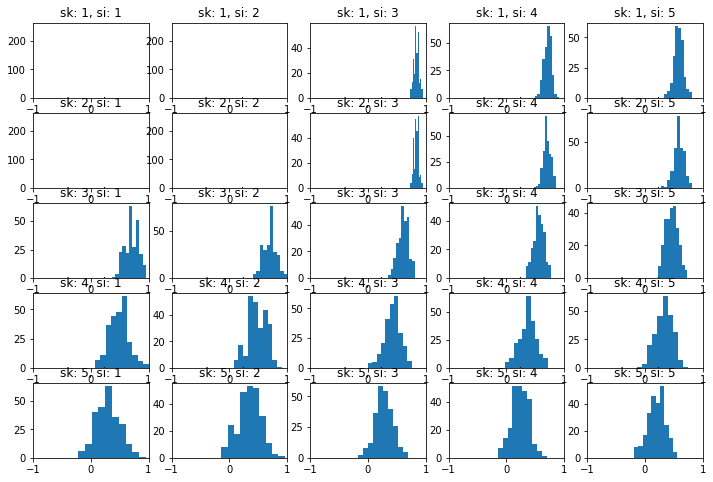

In [15]:
from itertools import permutations
from squirrel.iterstream import IterableSource
import matplotlib.pyplot as plt 
from scipy.stats import entropy
import numpy as np
from scipy.stats import kendalltau

N = 20
M = 5
num_shard = 10
shard_size = N // num_shard
driver = MyShardedDriver(num_shard, shard_size)
samples = 250


def diff_unnormalized(result1, result2):
    return np.sum(np.abs(np.array(result1) - np.array(result2)))


def normalize_diff(diff, n):
    return diff / (n ** 2)

# todo: find a good distance measure
def calc_diff(result1, result2):
    return normalize_diff(diff_unnormalized(result1, result2), len(result1))

f, ax = plt.subplots(M, M, figsize=(12, 8))

for shuffle_key_buffer in range(M):
    for shuffle_item_buffer in range(M):
        diffs = []
        diffs_true = []

        for i in range(samples):
            # diff between two randomly sampled trajectories
            result1 = driver.get_iter(shuffle_key_buffer=shuffle_key_buffer, shuffle_item_buffer=shuffle_item_buffer).collect()
            result2 = driver.get_iter(shuffle_key_buffer=shuffle_key_buffer, shuffle_item_buffer=shuffle_item_buffer).collect()
            #diffs.append(calc_diff(result1, result2))

            tau, p_value=kendalltau(result1, result2)
            diffs.append(tau)
        
        for i in range(samples):
            result1 = np.random.permutation(N) 
            result2 = np.random.permutation(N)
            #diffs_true.append(calc_diff(result1, result2))

            tau, p_value=kendalltau(result1, result2)
            diffs_true.append(tau)

        dist_bins = [normalize_diff(diff, N) for diff in range(diff_unnormalized(np.arange(N), np.arange(N-1,-1,-1)))]
        hist, _ = np.histogram(diffs, bins=dist_bins)
        hist_true, _ = np.histogram(diffs_true, bins=dist_bins)

        # print(f"key b. {shuffle_key_buffer}, item b. {shuffle_item_buffer}, diffs {np.mean(diffs):.4f} vs. {np.mean(diffs_true):.4f} random. diffs var {np.var(diffs):.4f} vs. {np.var(diffs_true):.4f} random. entropy {entropy(hist):.4f} vs. {entropy(hist_true):.4f}")

        ax[shuffle_key_buffer][shuffle_item_buffer].set_title(f"sk: {shuffle_key_buffer+1}, si: {shuffle_item_buffer+1}")
        ax[shuffle_key_buffer][shuffle_item_buffer].hist(diffs)
        ax[shuffle_key_buffer][shuffle_item_buffer].set_xlim(-1, 1)

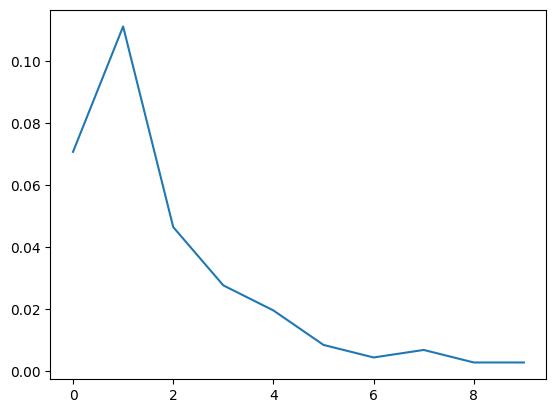

In [4]:
from squirrel.driver.quantify_randomness import quantify_randomness
import matplotlib.pyplot as plt

shard_size = 10
num_shard = 10
kendall = []

for buf_size in range(1,10):
    # assuming initial and buf size is the same
    r = quantify_randomness(num_shard, shard_size, buf_size, buf_size, 1000)
    kendall.append(r)

plt.plot(range(1,10), kendall)